# Cascadia Margin Lipid Modeling

In [1]:
from os.path import join
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## configuration

In [4]:
from matplotlib import style

In [5]:
style.use(join("..", "style.mplstyle"))
datadir = join("..", "data", "processed")

## load data

### relative abundance and d13C of GDGT compounds

In [6]:
df = pd.read_excel(join(datadir, "CascadiaMargin_carbon_abundance.xlsx"))
df.replace(
    {"Astoria Cyn": "Astoria Canyon", "Mcarthur cyn": "Mcarthur Canyon"}, inplace=True
)
df.sample(10)

Sample Name         Location    Compound  m_from_plume depth_int  \
13           S3   Astoria Canyon  Cren regio          20.0       2-3   
222        S106  Mcarthur Canyon          G4           NaN       NaN   
76          S40    Hydrate Ridge  Cren regio           0.0       3-4   
234        S109  Mcarthur Canyon          G2           0.0       0-1   
193        S100  Mcarthur Canyon          G3          30.0       3-4   
7            S3   Astoria Canyon        Cren          20.0       2-3   
183         S99  Mcarthur Canyon          G0          30.0       2-3   
187         S99  Mcarthur Canyon          G4           NaN       NaN   
216        S105  Mcarthur Canyon  Cren regio          60.0       2-3   
190        S100  Mcarthur Canyon          G0          30.0       3-4   

      avg_ugC     F2/F1    d13c_avg     stdev  purity_score  rel_abund  
13        NaN        NaN        NaN       NaN           NaN   0.004054  
222       NaN        NaN        NaN       NaN           NaN   0.002279  
76        NaN        NaN        NaN       NaN           NaN   0.032028  
234       NaN        NaN        NaN       NaN           NaN   0.042882  
193       NaN        NaN        NaN       NaN           NaN   0.004849  
7         NaN        NaN        NaN       NaN           NaN   0.287896  
183  2.145095  60.333202 -19.424045  0.167629      0.947248   0.453343  
187       NaN        NaN        NaN       NaN           NaN   0.004726  
216       NaN        NaN        NaN       NaN           NaN   0.012318  
190  5.046203  28.422672 -19.534238  0.100992      0.919479   0.449946

## Modeling

### data setup

unified table

In [7]:
data = df[["Sample Name", "Location", "Compound", "d13c_avg", "rel_abund"]]
data = data.pivot(columns="Compound", index=["Location", "Sample Name"])
data.head()

d13c_avg                                         \
Compound                       Cren Cren regio     G0     G1     G2     G3   
Location       Sample Name                                                   
Astoria Canyon S1            -22.73        NaN -30.91    NaN -83.71    NaN   
               S10           -31.55        NaN -35.05 -78.34 -91.61    NaN   
               S11           -36.44        NaN -36.78 -84.06 -96.46 -94.52   
               S3               NaN        NaN    NaN    NaN    NaN    NaN   
               S4            -23.87        NaN -48.29    NaN -85.14    NaN   

                               rel_abund                                 \
Compound                    G4      Cren Cren regio        G0        G1   
Location       Sample Name                                                
Astoria Canyon S1          NaN  0.306266   0.006217  0.389506  0.097763   
               S10         NaN  0.190468   0.003149  0.272736  0.108790   
               S11         NaN  0.151434   0.002418  0.251405  0.116905   
               S3          NaN  0.287896   0.004054  0.428023  0.118678   
               S4          NaN  0.219767   0.003197  0.481303  0.112187   

                                                          
Compound                          G2        G3        G4  
Location       Sample Name                                
Astoria Canyon S1           0.157369  0.042605  0.000274  
               S10          0.270738  0.134849  0.019270  
               S11          0.282700  0.168619  0.026520  
               S3           0.137595  0.020541  0.003213  
               S4           0.158765  0.021725  0.003057

relative abundance table

In [8]:
relative_abundance = data["rel_abund"]
relative_abundance.sample(5)

Compound                         Cren  Cren regio        G0        G1  \
Location        Sample Name                                             
Hydrate Ridge   S64          0.386958    0.005337  0.458261  0.082772   
                S61          0.334187    0.030837  0.471017  0.084228   
                S45          0.329312    0.029783  0.437343  0.098260   
Astoria Canyon  S11          0.151434    0.002418  0.251405  0.116905   
Mcarthur Canyon S112         0.416679    0.010363  0.443911  0.066924   

Compound                           G2        G3        G4  
Location        Sample Name                                
Hydrate Ridge   S64          0.061988  0.004394  0.000291  
                S61          0.073511  0.005952  0.000268  
                S45          0.096575  0.007564  0.001163  
Astoria Canyon  S11          0.282700  0.168619  0.026520  
Mcarthur Canyon S112         0.051334  0.006311  0.004478

In [9]:
assert all(np.isclose(relative_abundance.sum(axis=1).values, 1, rtol=1e-3))

In [10]:
relative_abundance.groupby(level=0).agg(["mean", "std"])

Compound             Cren           Cren regio                  G0            \
                     mean       std       mean       std      mean       std   
Location                                                                       
Astoria Canyon   0.224675  0.064108   0.003715  0.001278  0.372260  0.085086   
Hydrate Ridge    0.347191  0.054217   0.027648  0.014275  0.445803  0.027189   
Mcarthur Canyon  0.414666  0.012753   0.011919  0.001283  0.456852  0.013765   

Compound               G1                  G2                  G3            \
                     mean       std      mean       std      mean       std   
Location                                                                      
Astoria Canyon   0.114038  0.019510  0.201362  0.062735  0.074112  0.057568   
Hydrate Ridge    0.087193  0.022634  0.084481  0.048459  0.007215  0.005428   
Mcarthur Canyon  0.068284  0.004400  0.040850  0.004991  0.004701  0.000727   

Compound               G4            
                     mean       std  
Location                             
Astoria Canyon   0.009839  0.009523  
Hydrate Ridge    0.000469  0.000551  
Mcarthur Canyon  0.002732  0.001510

carbon isotopic fractionation table

In [11]:
d13C = data["d13c_avg"]
d13C.sample(5)

Compound                          Cren  Cren regio         G0         G1  \
Location        Sample Name                                                
Astoria Canyon  S5          -25.920000         NaN -63.310000 -73.350000   
Hydrate Ridge   S73         -19.410067         NaN -20.774908 -29.990956   
Mcarthur Canyon S93         -19.052799         NaN -20.849633        NaN   
                S101        -18.683568         NaN -19.374340 -20.103664   
Hydrate Ridge   S39         -19.791236         NaN -26.681803 -53.711971   

Compound                            G2  G3  G4  
Location        Sample Name                     
Astoria Canyon  S5          -93.320000 NaN NaN  
Hydrate Ridge   S73         -47.169938 NaN NaN  
Mcarthur Canyon S93                NaN NaN NaN  
                S101        -21.461305 NaN NaN  
Hydrate Ridge   S39         -67.926304 NaN NaN

In [12]:
d13C.groupby(level=0).agg(["mean", "std"])

Compound              Cren           Cren regio             G0             \
                      mean       std       mean std       mean        std   
Location                                                                    
Astoria Canyon  -27.500000  5.117011        NaN NaN -39.252857  12.583389   
Hydrate Ridge   -20.112818  1.751414        NaN NaN -25.830361  10.365047   
Mcarthur Canyon -18.948287  0.170264        NaN NaN -19.934959   0.935452   

Compound                G1                    G2                 G3            \
                      mean        std       mean        std    mean       std   
Location                                                                        
Astoria Canyon  -78.583333   5.359145 -89.108571   5.778086 -92.165  3.330473   
Hydrate Ridge   -46.454807  15.803619 -68.493641  15.006748     NaN       NaN   
Mcarthur Canyon -22.907023   5.434851 -28.755275  13.681861     NaN       NaN   

Compound          G4      
                mean std  
Location                  
Astoria Canyon   NaN NaN  
Hydrate Ridge    NaN NaN  
Mcarthur Canyon  NaN NaN

In [13]:
d13C.groupby(level=0).apply(lambda sl: sl.notnull().sum() / len(sl))

Compound          Cren  Cren regio     G0        G1        G2    G3   G4
Location                                                                
Astoria Canyon   0.875         0.0  0.875  0.375000  0.875000  0.25  0.0
Hydrate Ridge    1.000         0.0  1.000  1.000000  1.000000  0.00  0.0
Mcarthur Canyon  1.000         0.0  1.000  0.230769  0.230769  0.00  0.0

the order of the compounds and the lengths of different dimensions

In [14]:
GDGTs = ["G0", "G1", "G2", "G3", "G4", "Cren", "Cren regio"]
nchem = len(GDGTs)
communities = ["planktonic/autotrophic", "methanotrophic", "benthic"]
ncom = len(communities)
locations = data.index.levels[0]
nloc = len(locations)
locations

Index(['Astoria Canyon', 'Hydrate Ridge', 'Mcarthur Canyon'], dtype='object', name='Location')

ranges for the proportions of the compounds produced by each community, which go into the priors for `X`

In [15]:
X_lo = np.array(
    [
        [0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0],
        [0.2, 0.05, 0.2, 0.05, 0.0, 0.0, 0.0],
        [0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    ]
)
X_hi = np.array(
    [
        [0.8, 0.2, 0.1, 0.05, 1e-2, 0.5, 0.05],
        [0.5, 0.2, 0.5, 0.2, 0.1, 1e-2, 1e-2],
        [0.5, 0.3, 0.3, 0.3, 0.3, 1e-2, 0.1],
    ]
)

ranges for the dC13 values produced by each community, informing the priors for `D`

In [16]:
D_lo = np.array([-22, -120, -34])
D_hi = np.array([-18, -40, -24])

### model definition

In [17]:
with pm.Model() as model:

    # compositional priors for the contributions of different microbial communities
    F = pm.Dirichlet("F", a=np.full(ncom, 1.0), shape=(nloc, ncom))

    # production compositional priors for each compound in each community
    X_ = pm.Beta("X*", mu=(X_hi + X_lo) / 2, sigma=(X_hi - X_lo) / 4)
    # rows must be normalized (sum to 1)
    X = pm.Deterministic("X", X_ / pm.math.sum(X_, axis=1, keepdims=True))

    # relative abundance, given F and X
    M = pm.Deterministic("M", pm.math.dot(F, X))

    pm.Deterministic(
        "Methane Index",
        pm.math.sum(M[:, 1:4], axis=1, keepdims=True)
        / pm.math.sum(M[:, 1:], axis=1, keepdims=True),
    )

    # variance parameters for relative abundances
    sigma_abundance = pm.Beta("sigma abundance", alpha=1, beta=20, shape=(nloc, nchem))

    # relative abundance likelihood
    for i, location in enumerate(locations):
        pm.TruncatedNormal(
            f"{location}\nobserved\nabundance",
            mu=M[i, :],
            sigma=sigma_abundance[i, :],
            observed=relative_abundance[GDGTs].loc[location].values,
            lower=0,
            upper=1,
        )

    # delta C 13 end members
    D = pm.Normal("D", mu=(D_hi + D_lo) / 2, sigma=(D_hi - D_lo) / 4)

    C = pm.Deterministic("C", pm.math.dot(F * D, X) / M)

    sigma_d13c = pm.Exponential("sigma d13C", scale=25, shape=(nloc, nchem))

    for i, location in enumerate(locations):
        for j, compound in enumerate(GDGTs):
            d = d13C[compound].loc[location].dropna().values
            if len(d) > 0:
                pm.Normal(
                    f"{location}\nobserved\n{compound} d13C",
                    mu=C[i, j],
                    sigma=sigma_d13c[i, j],
                    observed=d,
                )

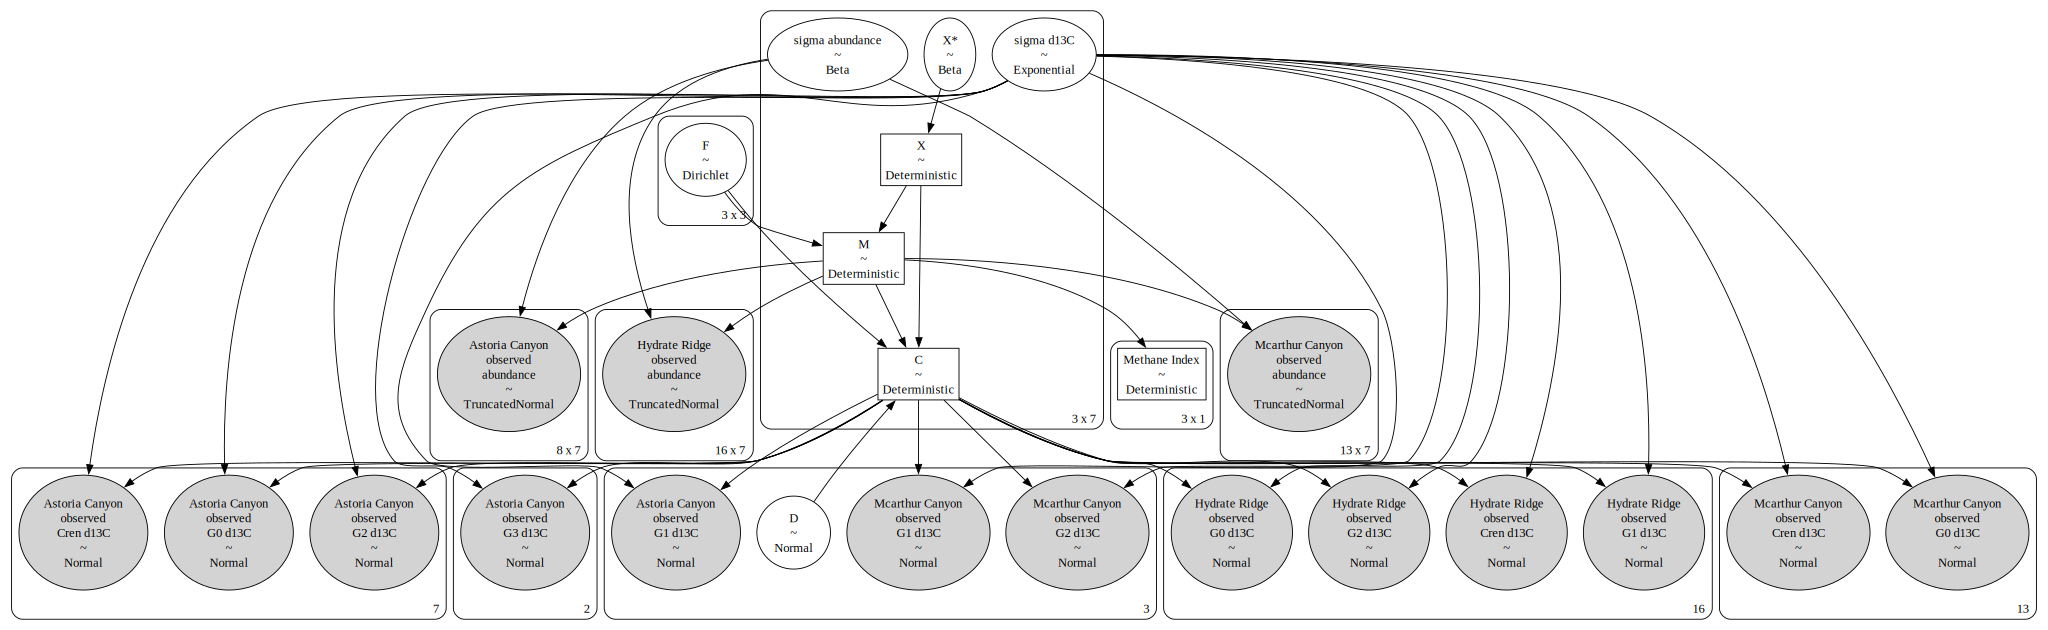

In [18]:
pm.model_to_graphviz(model)

### prior predictive checks

In [19]:
with model:
    prior = pm.sample_prior_predictive(samples=32_000)
prior.prior.to_netcdf("../model-results/prior.nc")

Sampling: [Astoria Canyon
observed
Cren d13C, Astoria Canyon
observed
G0 d13C, Astoria Canyon
observed
G1 d13C, Astoria Canyon
observed
G2 d13C, Astoria Canyon
observed
G3 d13C, Astoria Canyon
observed
abundance, D, F, Hydrate Ridge
observed
Cren d13C, Hydrate Ridge
observed
G0 d13C, Hydrate Ridge
observed
G1 d13C, Hydrate Ridge
observed
G2 d13C, Hydrate Ridge
observed
abundance, Mcarthur Canyon
observed
Cren d13C, Mcarthur Canyon
observed
G0 d13C, Mcarthur Canyon
observed
G1 d13C, Mcarthur Canyon
observed
G2 d13C, Mcarthur Canyon
observed
abundance, X*, sigma abundance, sigma d13C]


<Figure size 960x720 with 0 Axes>

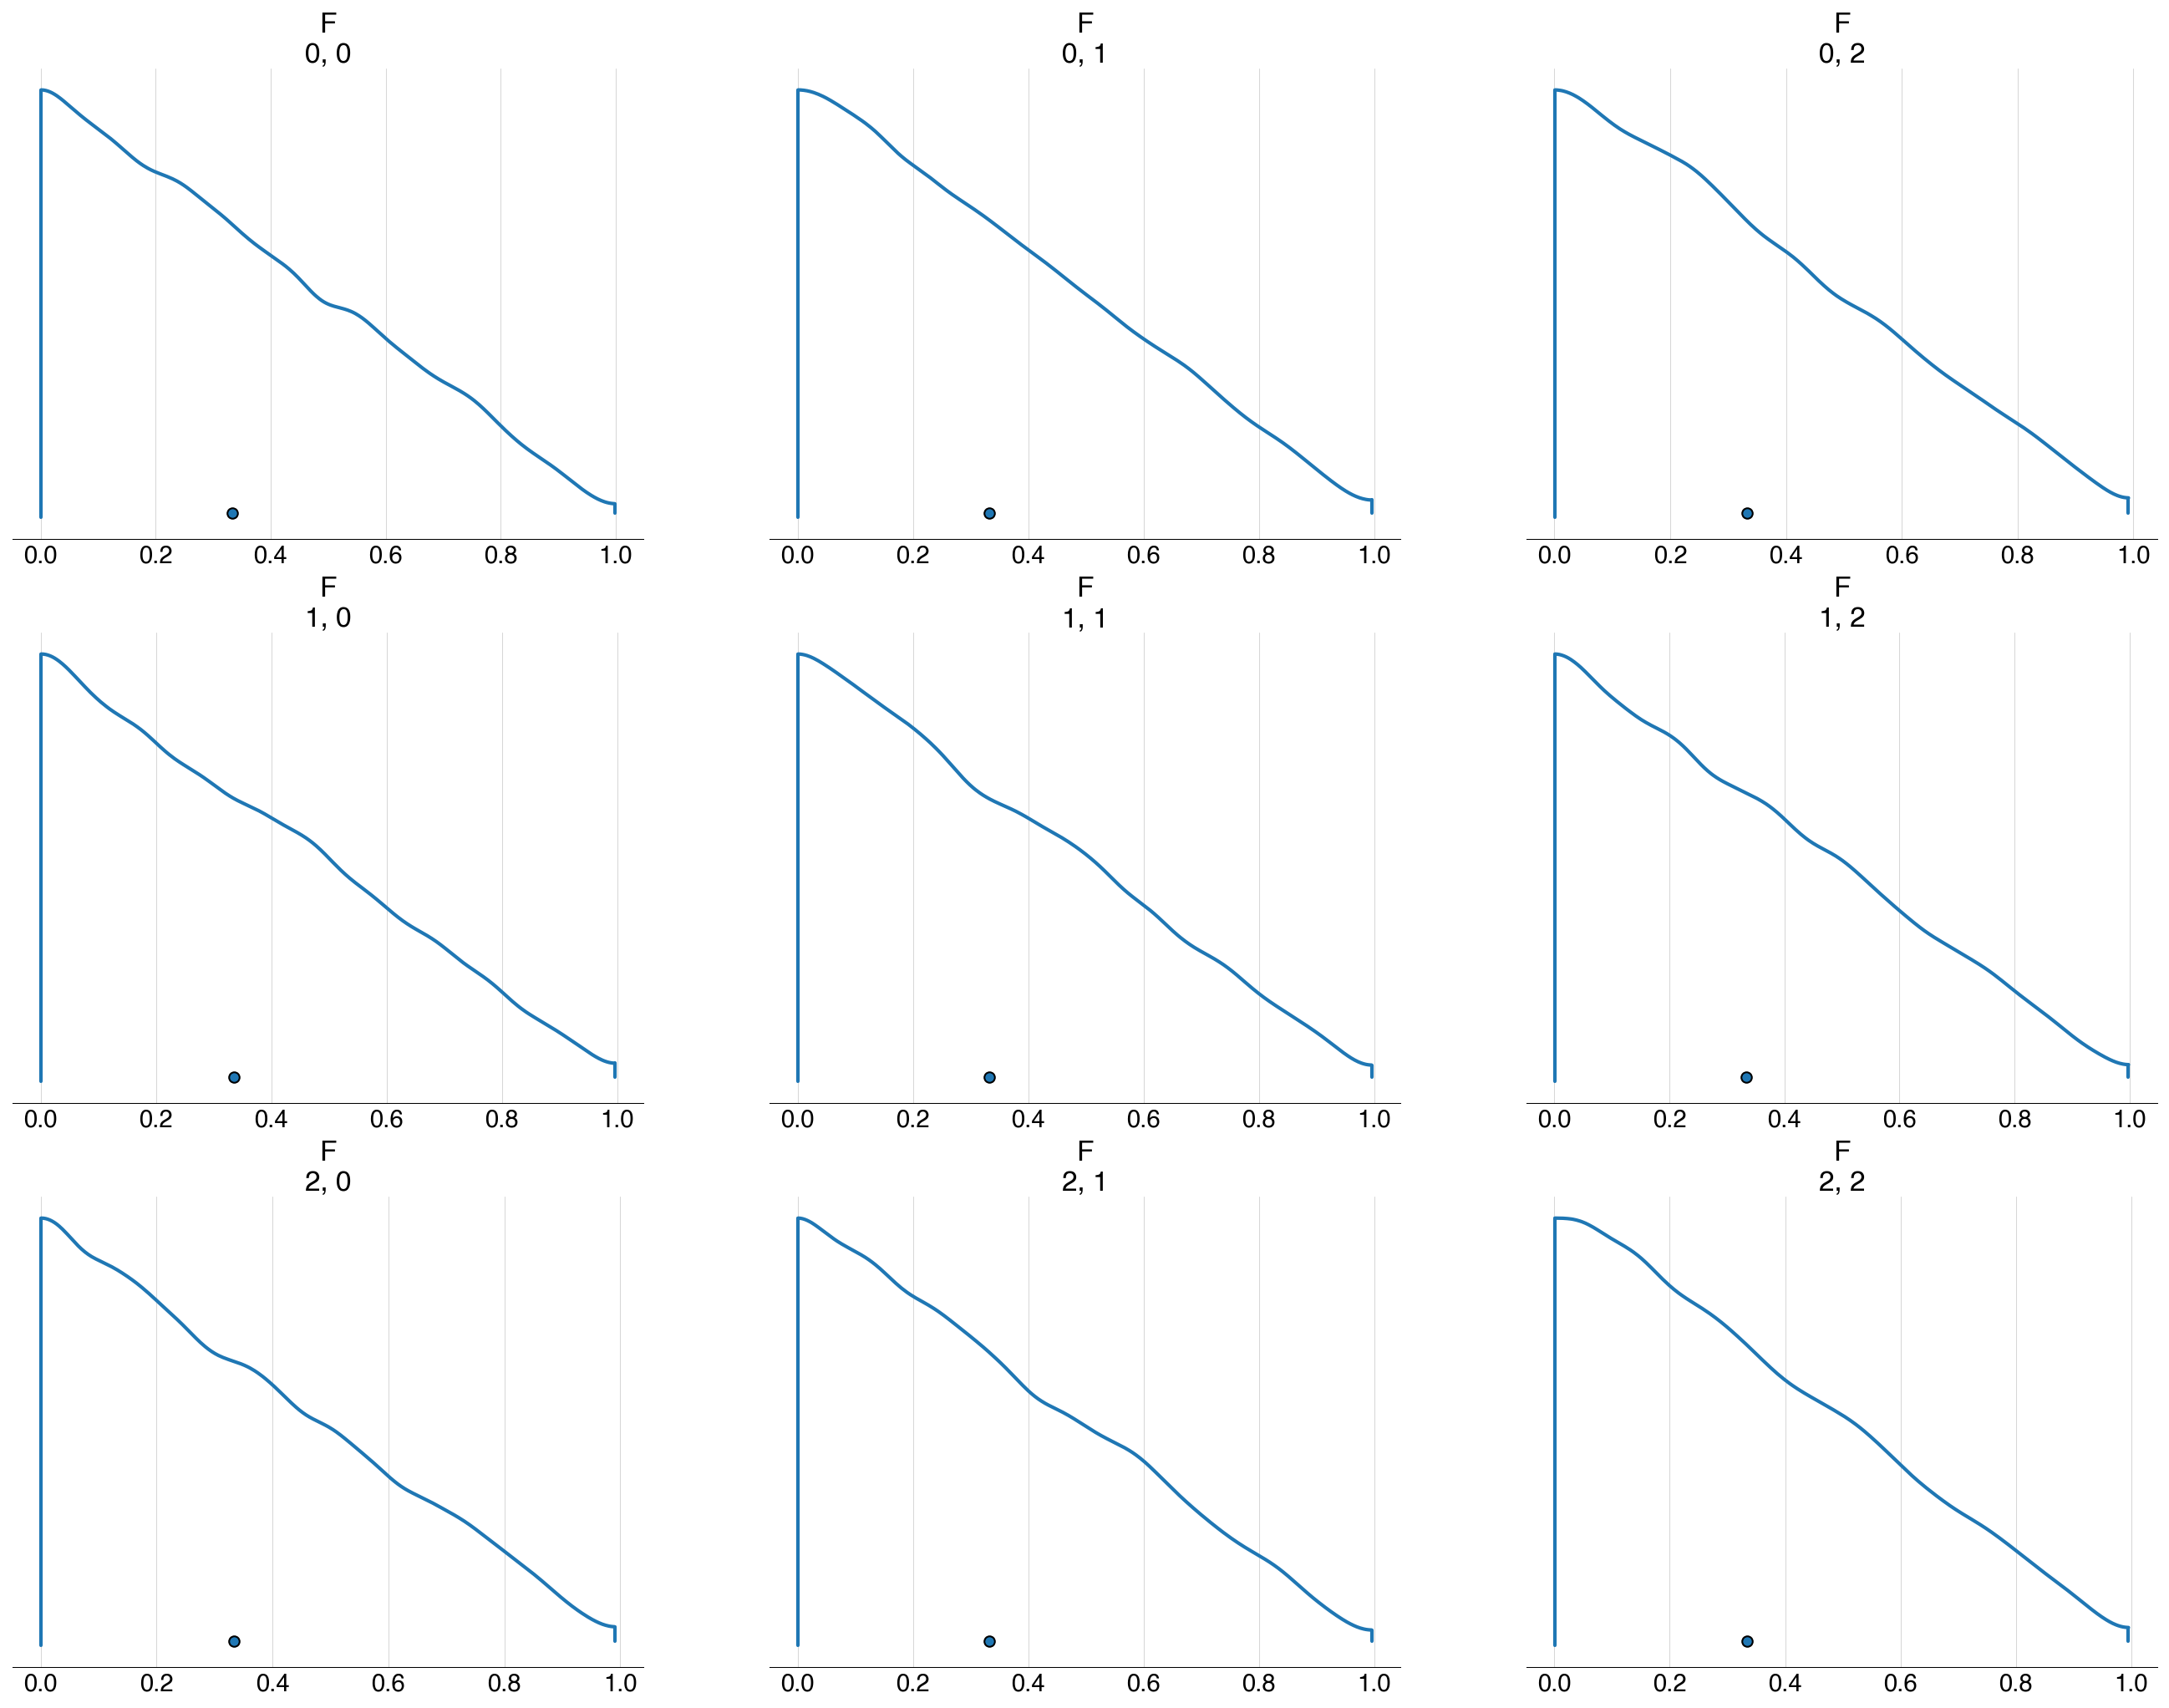

In [20]:
fig = plt.figure()
az.plot_density(prior.prior, var_names="F", hdi_prob=1, grid=(3, 3))
fig.tight_layout()

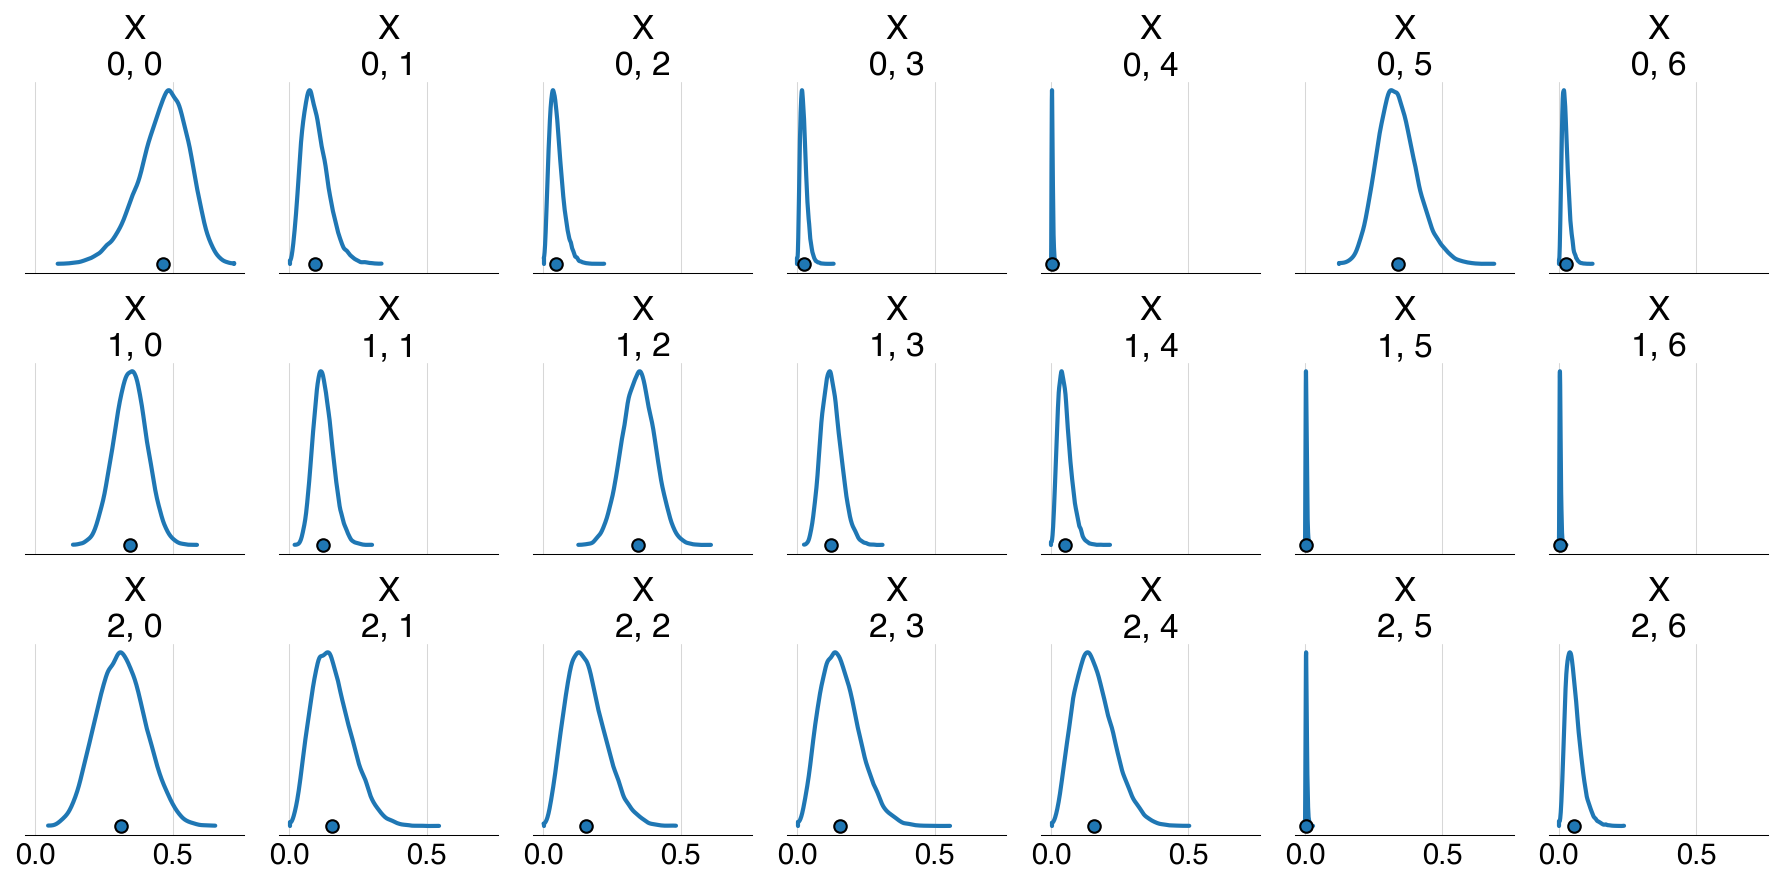

In [21]:
fig, axs = plt.subplots(3, 7, figsize=(12, 6), sharex=True)
az.plot_density(prior.prior, var_names="X", hdi_prob=1, ax=axs)
fig.tight_layout()

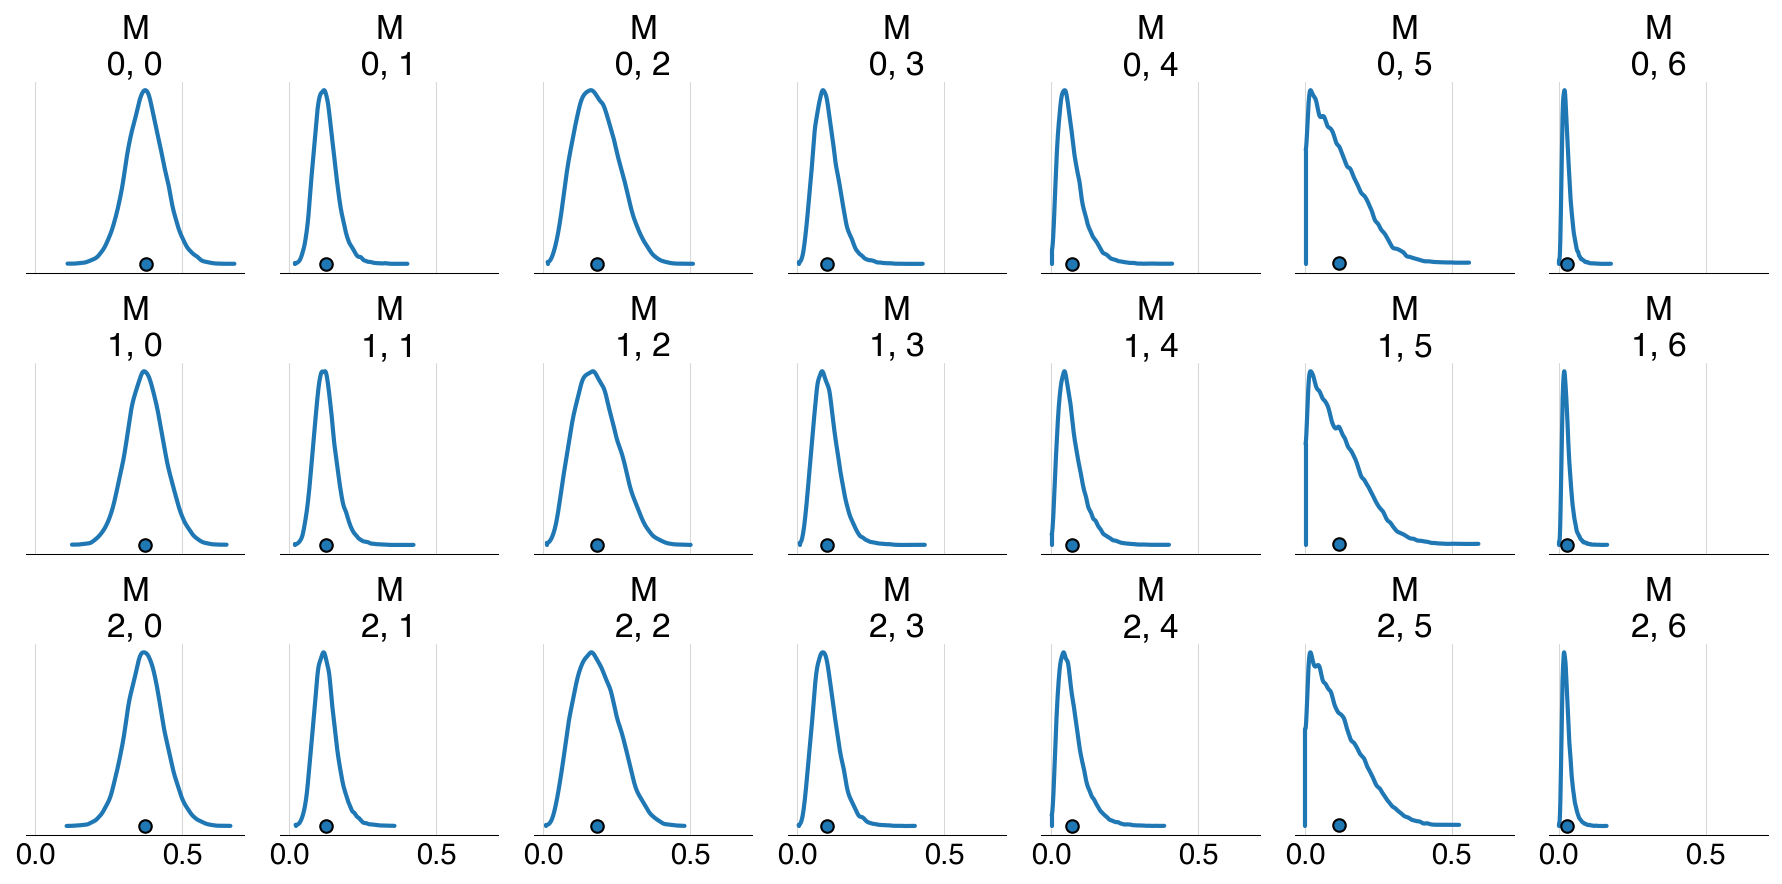

In [22]:
fig, axs = plt.subplots(3, 7, figsize=(12, 6), sharex=True)
az.plot_density(prior.prior, var_names="M", hdi_prob=1, ax=axs)
fig.tight_layout()

<Figure size 960x720 with 0 Axes>

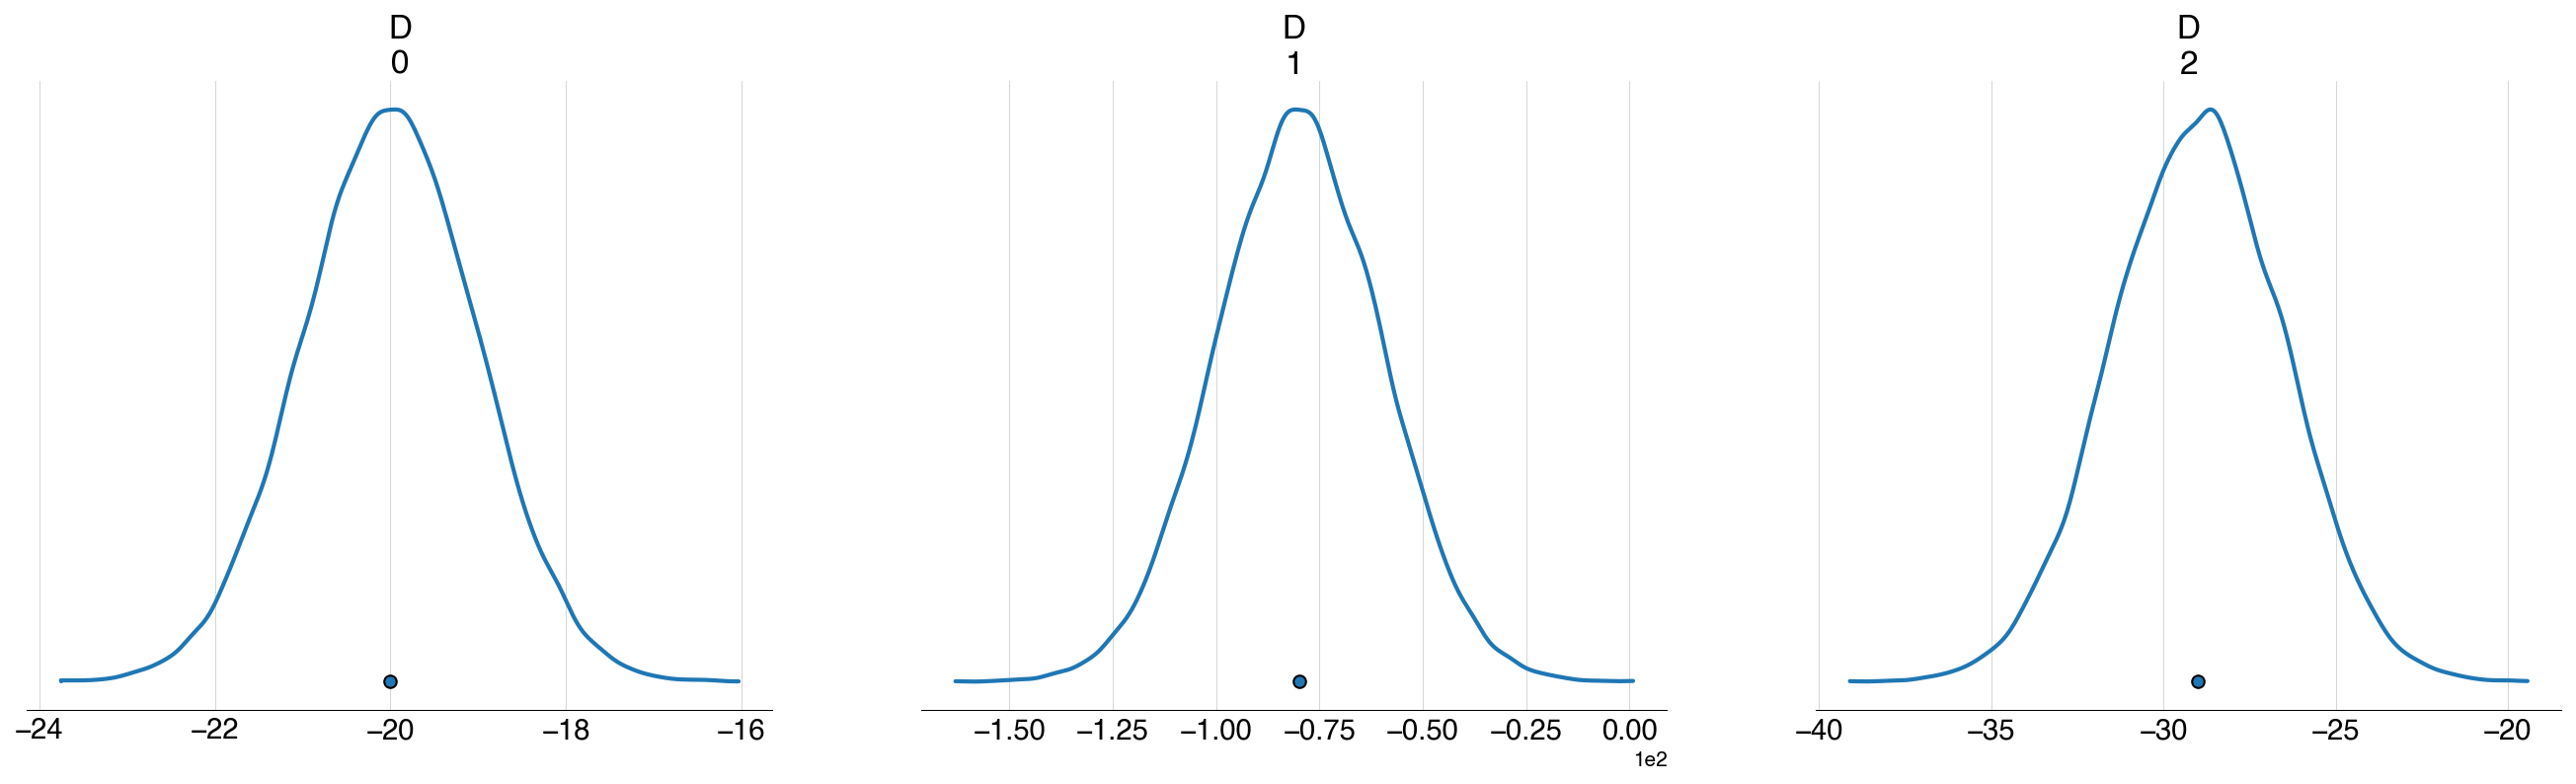

In [23]:
fig = plt.figure()
az.plot_density(prior.prior, var_names="D", hdi_prob=1)
fig.tight_layout()

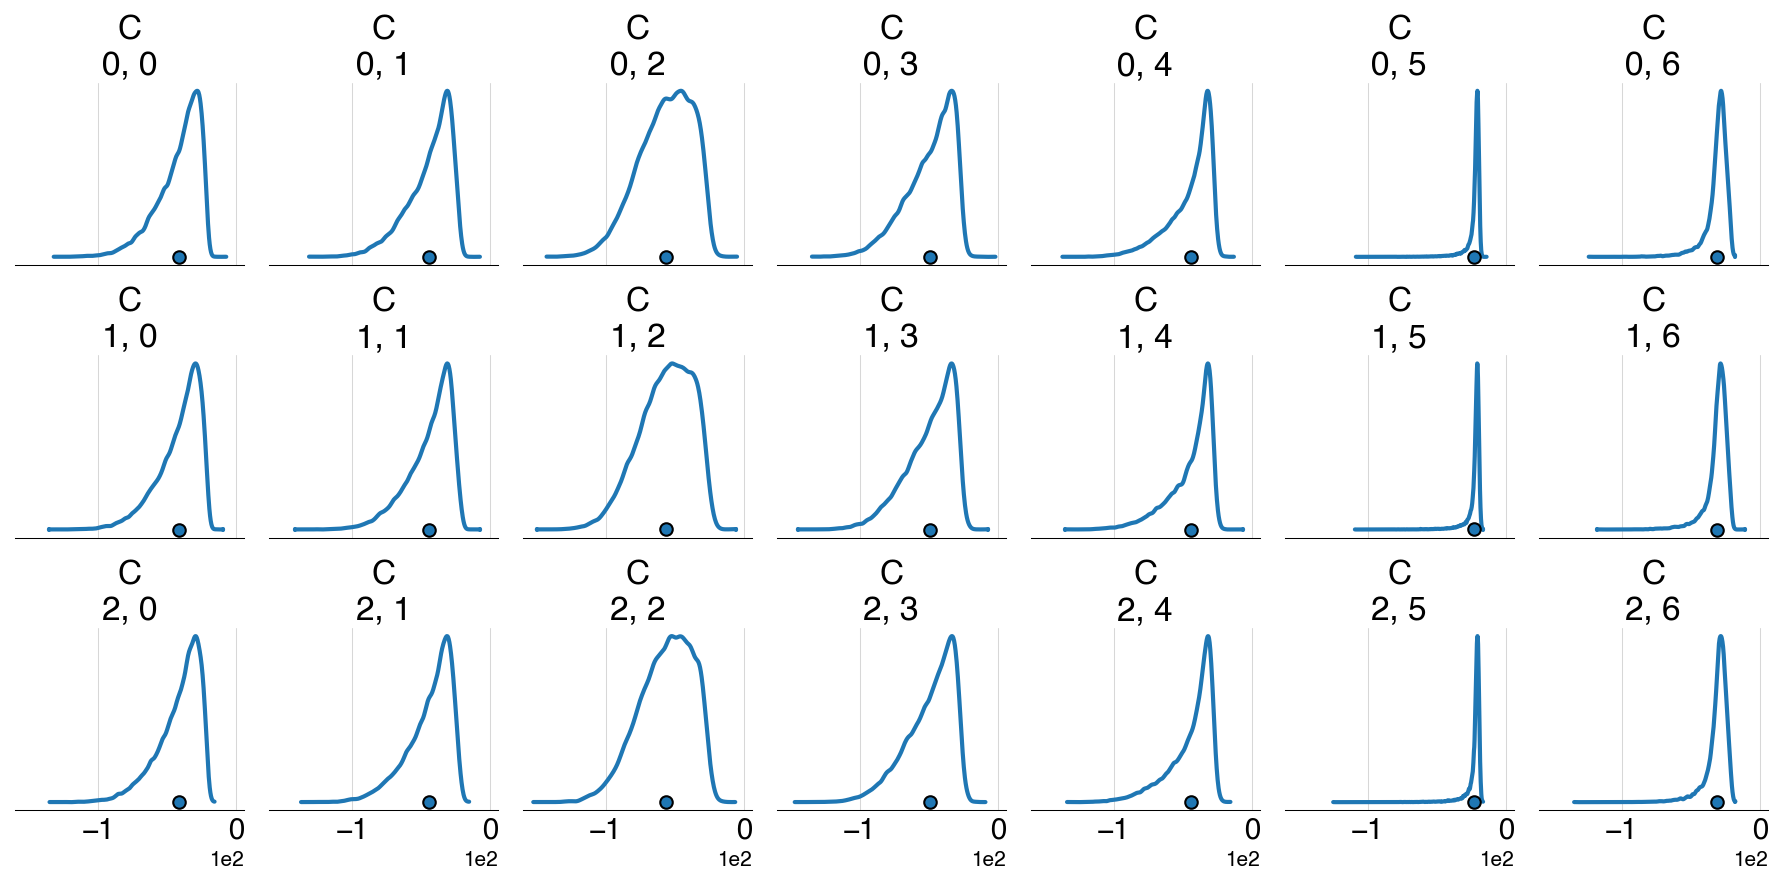

In [24]:
fig, axs = plt.subplots(3, 7, figsize=(12, 6), sharex=True)
az.plot_density(prior.prior, var_names="C", hdi_prob=1, ax=axs)
fig.tight_layout()

### posterior sampling

In [25]:
with model:
    post = pm.sample(cores=16, chains=16, tune=4_000, draws=4_000, target_accept=0.975)
post.posterior.to_netcdf("../model-results/posterior.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [F, X*, sigma abundance, D, sigma d13C]


Sampling 16 chains for 4_000 tune and 4_000 draw iterations (64_000 + 64_000 draws total) took 574 seconds.


### posterior checks

### rhat

In [26]:
rhat = az.rhat(post)

In [27]:
rhat["F"]

<xarray.DataArray 'F' (F_dim_0: 3, F_dim_1: 3)> Size: 72B
array([[1.00008498, 1.00005323, 1.00060282],
       [1.00007726, 1.00008259, 1.00014198],
       [1.00031897, 1.00019481, 1.00034527]])
Coordinates:
  * F_dim_0  (F_dim_0) int64 24B 0 1 2
  * F_dim_1  (F_dim_1) int64 24B 0 1 2

In [28]:
rhat["X"]

<xarray.DataArray 'X' (X_dim_0: 3, X_dim_1: 7)> Size: 168B
array([[1.00027321, 1.00005096, 1.00003055, 1.000086  , 1.00002838,
        1.00019701, 1.00026862],
       [1.00007596, 0.99993644, 1.00008281, 1.00019821, 1.00013233,
        1.00006685, 1.00003302],
       [1.00007043, 1.00020887, 1.00016974, 1.00028807, 1.00005237,
        1.00014691, 1.00037622]])
Coordinates:
  * X_dim_0  (X_dim_0) int64 24B 0 1 2
  * X_dim_1  (X_dim_1) int64 56B 0 1 2 3 4 5 6

In [29]:
rhat["D"]

<xarray.DataArray 'D' (D_dim_0: 3)> Size: 24B
array([1.00004797, 1.0000936 , 1.00071547])
Coordinates:
  * D_dim_0  (D_dim_0) int64 24B 0 1 2

#### ESS

In [30]:
ess = az.ess(post)

In [31]:
ess["F"]

<xarray.DataArray 'F' (F_dim_0: 3, F_dim_1: 3)> Size: 72B
array([[74109.23491372, 63681.62554589, 33671.14453565],
       [61594.02883156, 62808.6036683 , 40802.60834692],
       [25363.79564712, 46131.27146196, 20547.63611548]])
Coordinates:
  * F_dim_0  (F_dim_0) int64 24B 0 1 2
  * F_dim_1  (F_dim_1) int64 24B 0 1 2

In [32]:
ess["X"]

<xarray.DataArray 'X' (X_dim_0: 3, X_dim_1: 7)> Size: 168B
array([[ 67593.46364852,  51894.73451036,  60136.30872157,
         46819.2634329 ,  99335.45632397,  32511.93630972,
         25425.83572902],
       [ 99707.96811806,  81062.36140569,  93952.46686673,
         90987.68957591,  94769.21122321,  91833.30890421,
         90012.53114494],
       [ 99649.42128294, 105781.48388608,  92617.02282323,
         52819.53871505,  44933.03947119, 114134.50196075,
         38843.7283705 ]])
Coordinates:
  * X_dim_0  (X_dim_0) int64 24B 0 1 2
  * X_dim_1  (X_dim_1) int64 56B 0 1 2 3 4 5 6

In [33]:
ess["D"]

<xarray.DataArray 'D' (D_dim_0: 3)> Size: 24B
array([ 84164.00800558,  51252.85690839, 152330.64075163])
Coordinates:
  * D_dim_0  (D_dim_0) int64 24B 0 1 2

#### traces

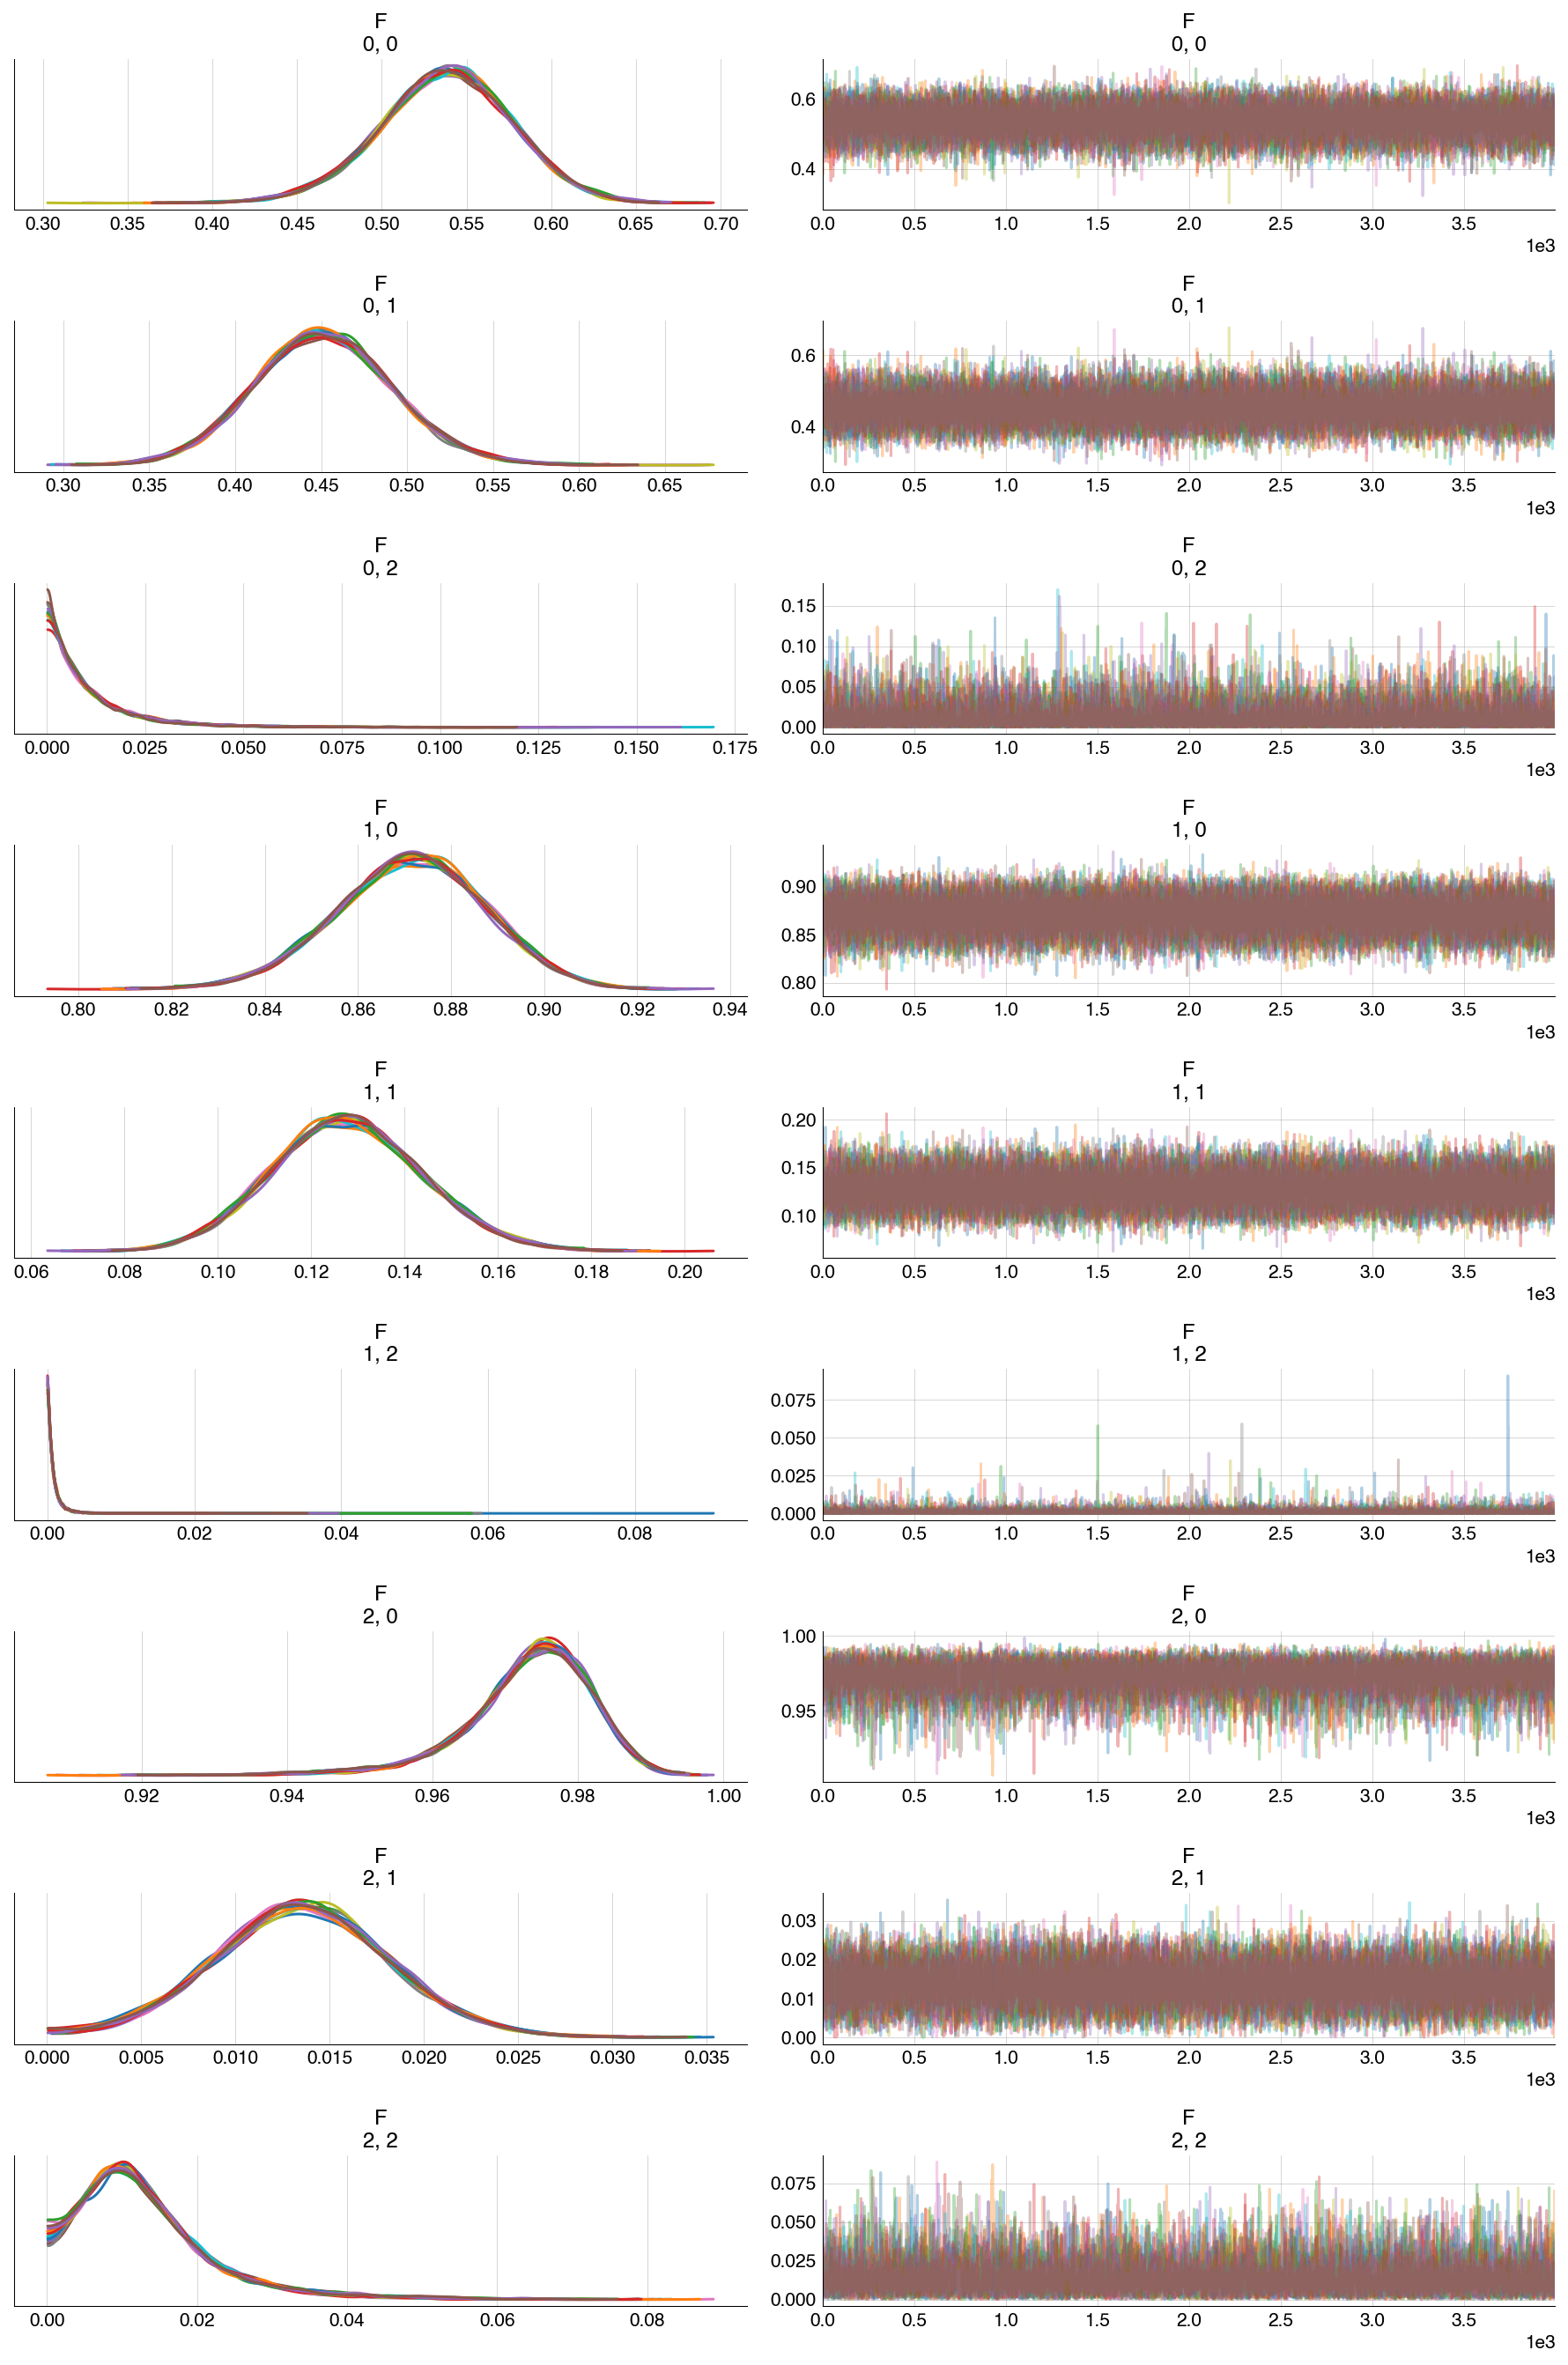

In [34]:
az.plot_trace(post, var_names=["F"], compact=False)
plt.gcf().tight_layout()

/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


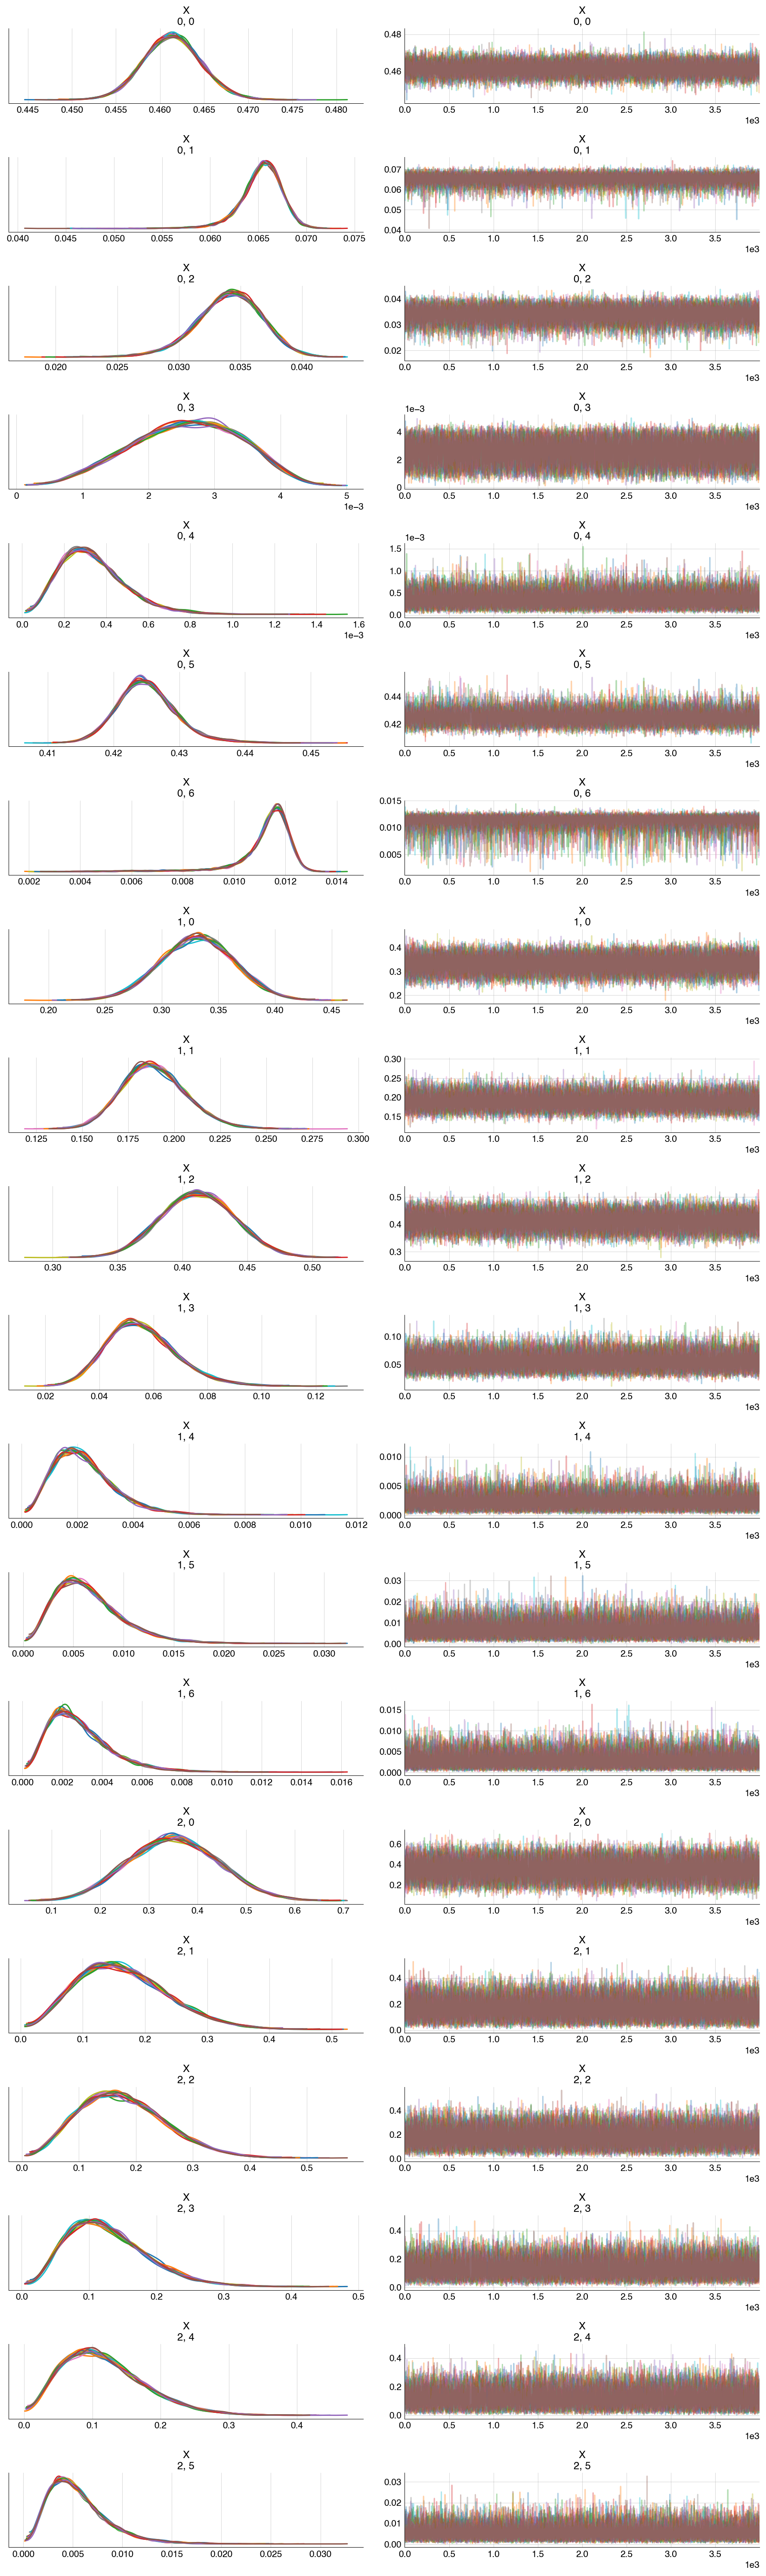

In [35]:
az.plot_trace(post, var_names="X", compact=False)
plt.gcf().tight_layout()

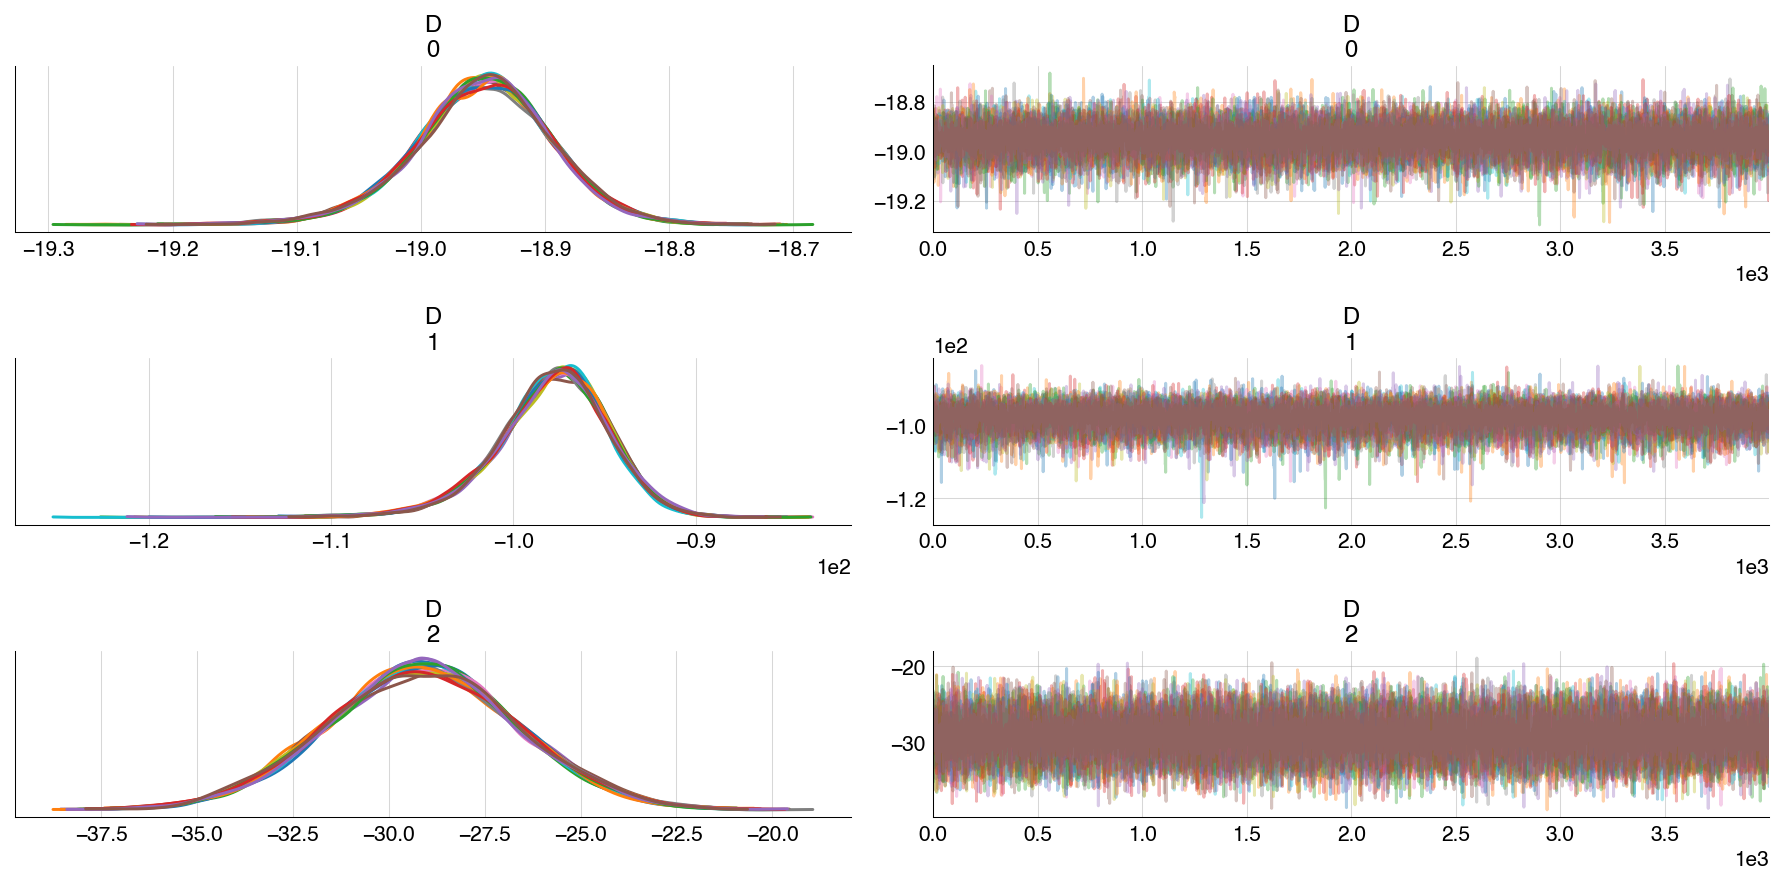

In [36]:
az.plot_trace(post, var_names=["D"], compact=False)
plt.gcf().tight_layout()

### posterior predictive

In [37]:
with model:
    ppc = pm.sample_posterior_predictive(post)
ppc.posterior_predictive.to_netcdf("../model-results/posterior_predictive.nc")

Sampling: [Astoria Canyon
observed
Cren d13C, Astoria Canyon
observed
G0 d13C, Astoria Canyon
observed
G1 d13C, Astoria Canyon
observed
G2 d13C, Astoria Canyon
observed
G3 d13C, Astoria Canyon
observed
abundance, Hydrate Ridge
observed
Cren d13C, Hydrate Ridge
observed
G0 d13C, Hydrate Ridge
observed
G1 d13C, Hydrate Ridge
observed
G2 d13C, Hydrate Ridge
observed
abundance, Mcarthur Canyon
observed
Cren d13C, Mcarthur Canyon
observed
G0 d13C, Mcarthur Canyon
observed
G1 d13C, Mcarthur Canyon
observed
G2 d13C, Mcarthur Canyon
observed
abundance]


/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


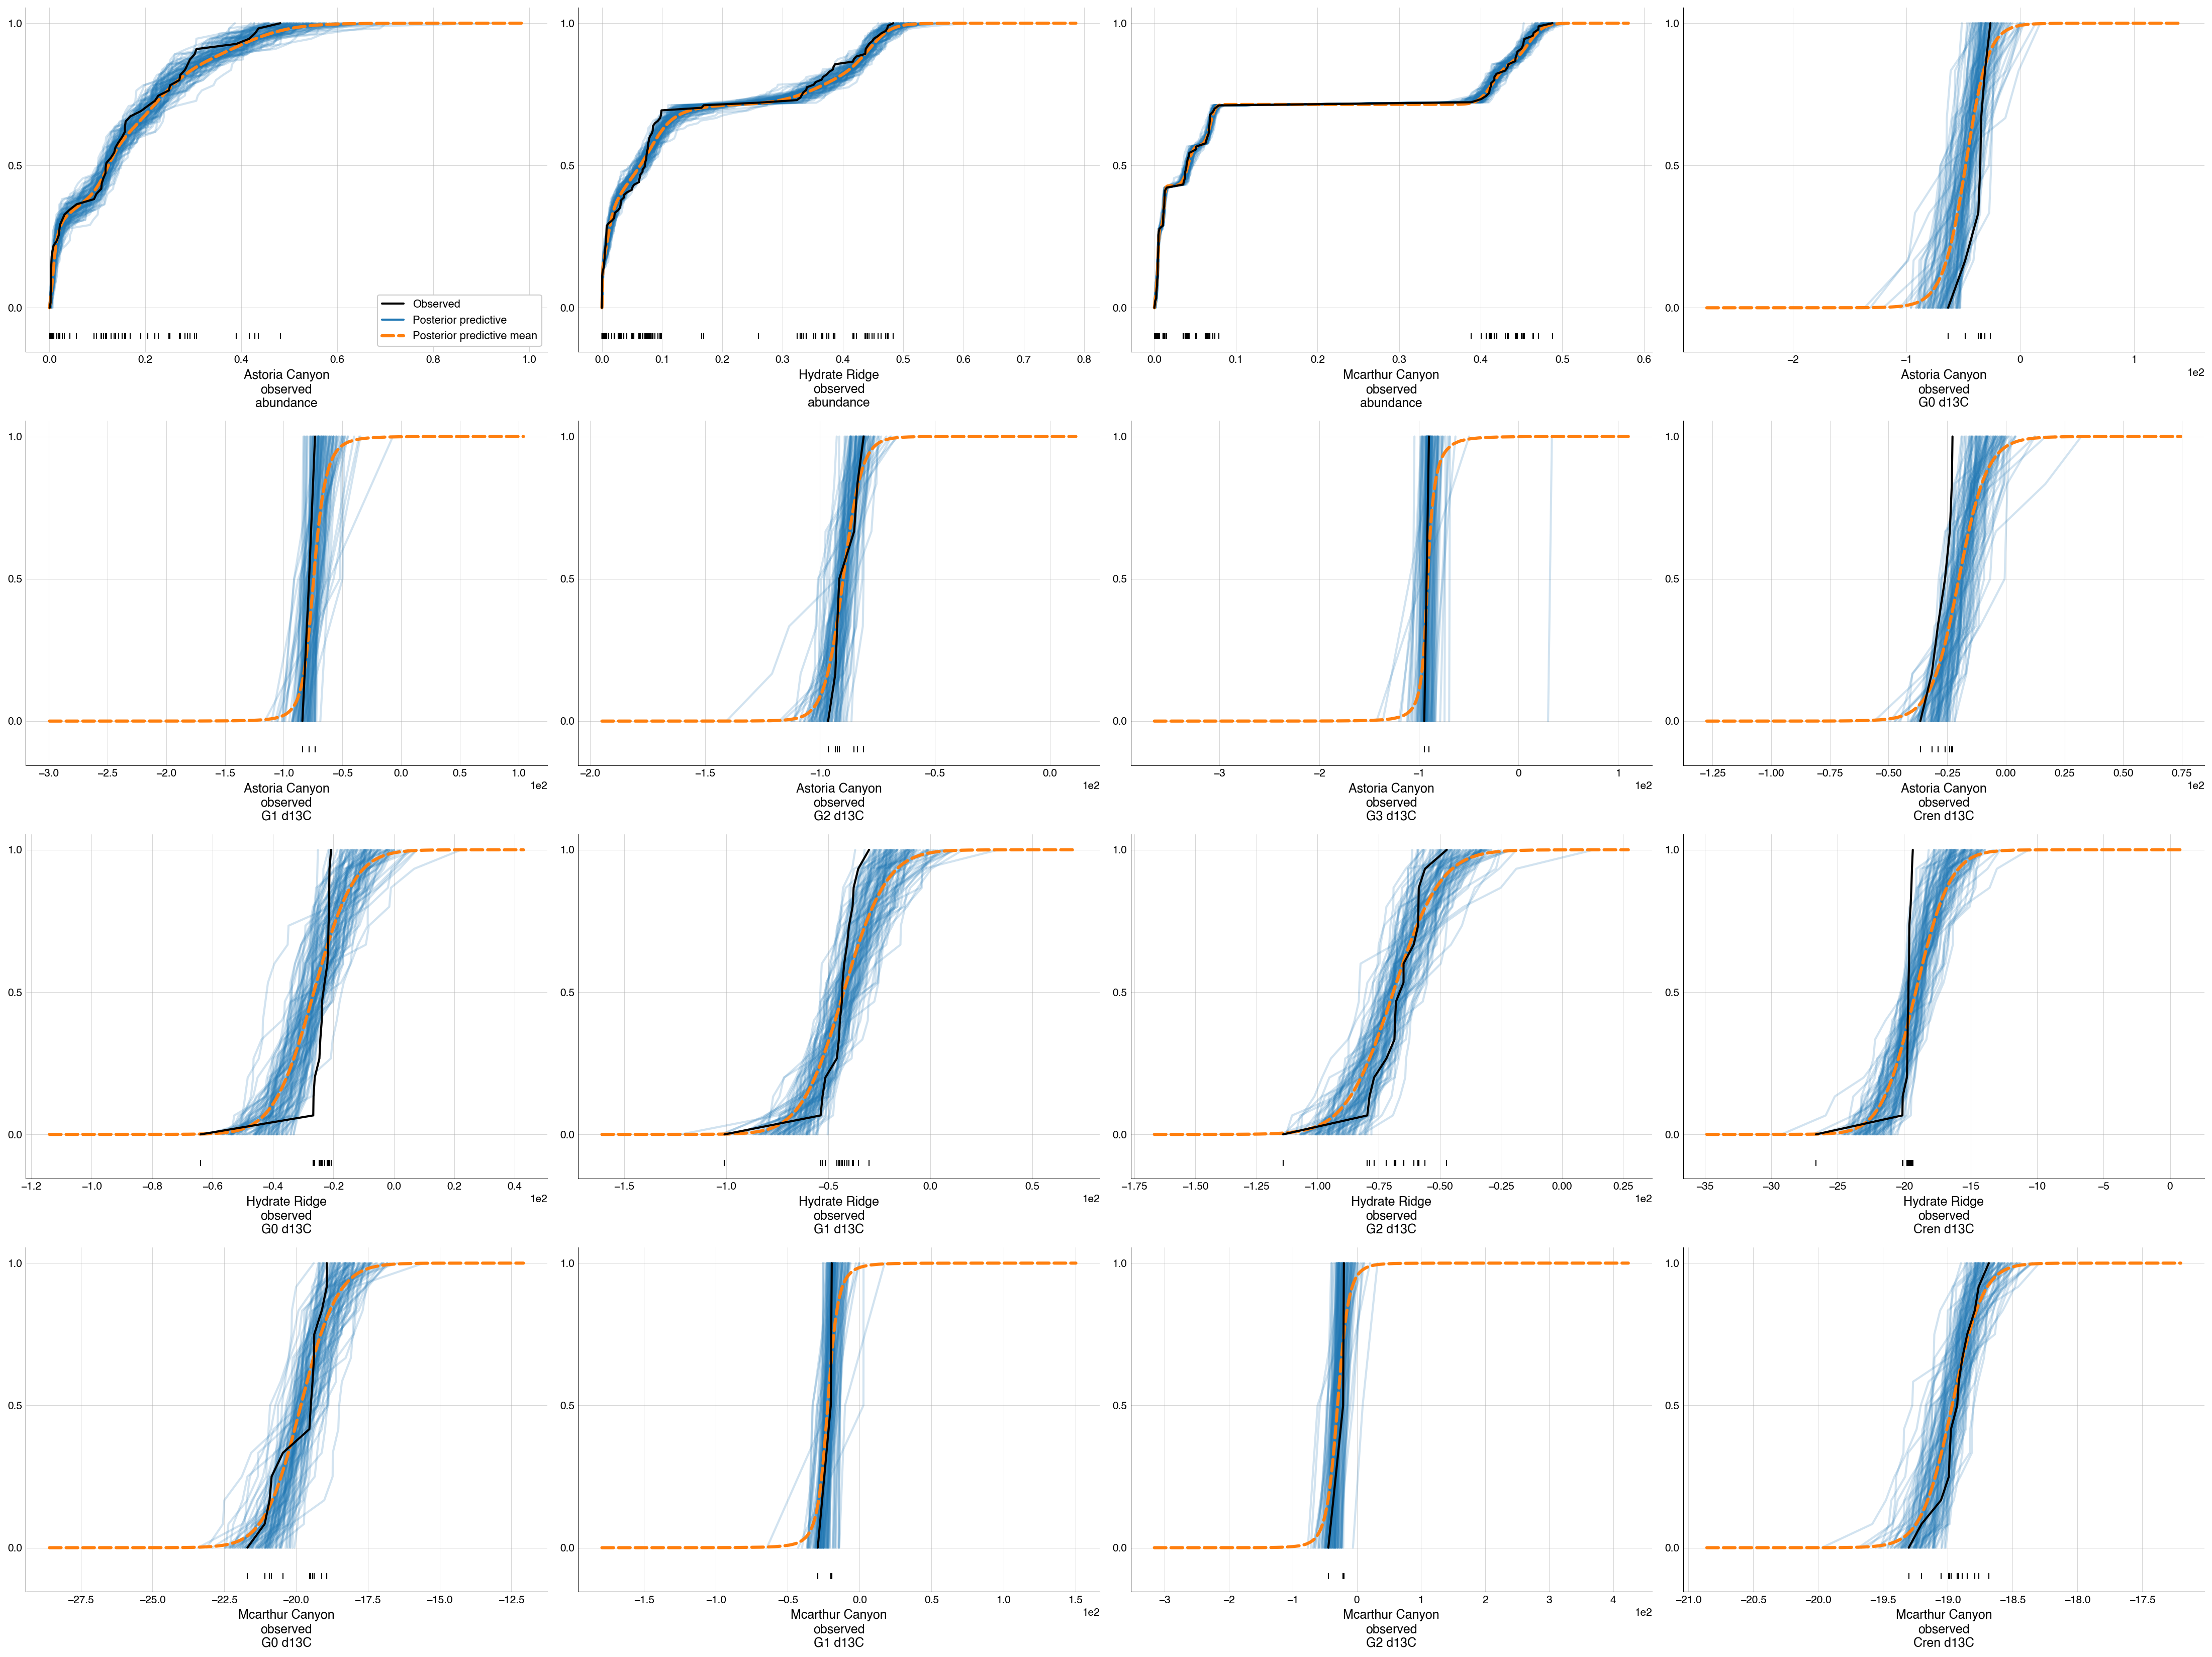

In [38]:
az.plot_ppc(ppc, num_pp_samples=100, observed_rug=True, kind="cumulative")
plt.gcf().tight_layout()